# Setup

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import random
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [30]:
def set_seed(seed):
    """
    This method helps to seed the libraries, it is important to get reproducible results
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
set_seed(42)

In [31]:
base = "/content/drive/MyDrive/data_soli_dictionaries/"
from google.colab import drive
drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {}".format(device))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cuda


# Data Setup

In [32]:
import pickle

def get_data(train,remove_gestures): 
  if train:
    with open(base+'train.pickle', 'rb') as f:
        data = pickle.load(f)
  else:
    with open(base+'test.pickle', 'rb') as f:
      data = pickle.load(f)

  X = []
  y = []
  lengths = []
  
  if remove_gestures is not None:
    keys = np.zeros(11-len(remove_gestures),dtype=int)
    j=0
    for i in range(11):
      if i not in remove_gestures:
        keys[j]=i
        j= j+1
  else:
    keys = np.arange(11)
    
  keys = list(keys)

  for key in keys:
    gesture_data = data[key]
    for i in range(len(gesture_data)):
      datapt_arr = gesture_data[i]
      datapt = None
      first = True
      for i in range(4):
        if first:
          datapt = np.sum(datapt_arr[i],axis=2)
          first = False
        else:
          datapt = np.concatenate((datapt,np.sum(datapt_arr[i],axis=2)),axis=1)
      for i in range(4):
        datapt = np.concatenate((datapt,np.sum(datapt_arr[i],axis=1)),axis=1)

      """
      minimum = datapt.min()
      maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
      datapt = (datapt-minimum)/((maximum-minimum)) 
      """

      X.append(datapt)
      y_temp = np.zeros(11-len(remove_gestures))
      y_temp[keys.index(key)]=1
      y.append(y_temp)
      lengths.append(np.shape(datapt)[0])


  lengths = np.array(lengths)
  return X,y,lengths

In [33]:
def padding_data (X,X_len):
  longest = max(X_len)
  dimx = np.shape(X[0])[1]
  
  for i in range(len(X_len)):
    if X_len[i] < longest:
      usex = np.zeros((longest-X_len[i],dimx))
      X[i] = np.vstack((X[i],usex))

  return X

In [34]:
from sklearn.model_selection import train_test_split
def test_val_split(X_test_use,y_test_use,X_test_len_use,remove):
  X_val =[]
  y_val =[]
  X_test=[]
  y_test=[]
  X_test_len=[]
  X_val_len=[]
  count = 124
  for i in range(11-len(remove)):
    val_X,test_X,val_y,test_y,val_len,test_len = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],X_test_len_use[i*count:(i+1)*(count)],test_size=0.50,random_state=2)
    X_val.extend(val_X)
    X_test.extend(test_X)
    y_val.extend(val_y)
    y_test.extend(test_y)
    X_val_len.extend(val_len)
    X_test_len.extend(test_len)
  return X_test,y_test,X_test_len,X_val,y_val,X_val_len

In [35]:
from torch.utils.data import Dataset

class SoliData(Dataset):
  def __init__(self, train,X_train,y_train,train_len,X_test,y_test,test_len,X_val,y_val,val_len):
        if train=="Train":
            self.data= X_train               # in this just define dataset of train and test after split into self.data
            self.target = y_train
            self.len = train_len
        elif train=="Test":
            self.data = X_test
            self.target = y_test
            self.len = test_len  
        else:
            self.data = X_val
            self.target = y_val 
            self.len = val_len            

  def __getitem__(self, index):
        target = self.target[index]                                                     # gets data point sequentially
        x = self.data[index]
        size = self.len[index]
        return x, target, size

  def __len__(self):
        return len(self.data)                                                      

In [36]:
X_train,y_train,X_train_len = get_data(True,[])
X_train = padding_data(X_train,X_train_len)
X_test_use,y_test_use,X_test_len_use = get_data(False,[])
X_test_use = padding_data(X_test_use,X_test_len_use)
X_test,y_test,X_test_len,X_val,y_val,X_val_len = test_val_split(X_test_use,y_test_use,X_test_len_use,[])

# Model Architecture

In [37]:
class attn_net(nn.Module):
  """
  This is the overall class implementing the LSTM architecture
  """

  def __init__(self,num_layers,num_cells,num_features_inp,bidir,neurons1,dropout_fc,dropout_lstm):
    """
    num_layers = Number of vertical stacking layers
    num_cells = Number of horizontal cells in a single layer
    num_features_inp = Number of features in the input of a single time step
    bidir = Whether LSTM is bidirectional or not
    neurons1 = Number of Neurons in the First FC layer after LSTM
    """

    super(attn_net, self).__init__()
    self.num_cells= num_cells
    self.num_features_inp = num_features_inp  ## 256
    self.bidir = bidir
    self.neurons1 = neurons1
    self.num_layers = num_layers
    self.dropout_fc=dropout_fc
    self.dropout_lstm = dropout_lstm
    

    rnns = nn.ModuleList()
    for i in range(self.num_layers):

      input_size_u = self.num_features_inp if i == 0 else self.num_cells
      lstm_layer = nn.LSTM(input_size = input_size_u, hidden_size = self.num_cells, num_layers = 1, batch_first = True,bidirectional = self.bidir) 

      for names in lstm_layer._all_weights:
        for name in filter(lambda n: "bias" in n,  names):
          bias = getattr(lstm_layer, name)
          n = bias.size(0)
          start, end = n//4, n//2
          bias.data[start:end].fill_(1.)
      rnns.append(lstm_layer)

    self.rnns = rnns
    self.pool = nn.AdaptiveMaxPool1d(1)
    size = 0 
    if self.bidir:
      size = 2*self.num_cells
    else:
      size = self.num_cells
    self.fc1 = nn.Linear(size,self.neurons1)
    self.fc2 = nn.Linear(self.neurons1,11)

    self.bn1 = nn.BatchNorm1d(size)
    self.bn2 = nn.BatchNorm1d(self.neurons1)

    self.lstm_dropout = nn.Dropout(p=self.dropout_lstm,inplace=True)
    self.fc_dropout = nn.Dropout(p=self.dropout_fc)

  def forward(self,X,X_lengths):
    """
    Forward Loop of LSTM.
    """
    X = pack_padded_sequence(X, X_lengths.cpu(), batch_first=True,enforce_sorted=False)   ## To hide the pad from LSTM 
    outputs = []

    for i in range(self.num_layers):

      output, _ = self.rnns[i](X)

      if i< (self.num_layers-1):
        output, lens = pad_packed_sequence(output,batch_first=True)
        self.lstm_dropout(output)
        output = pack_padded_sequence(output, lens.cpu(),batch_first=True,enforce_sorted=False)
      
      outputs.append(output)
      X = output
    
    X, _ = pad_packed_sequence(outputs[0], batch_first=True) 
    
    for i in range(1,self.num_layers):
      temp,_ = pad_packed_sequence(outputs[i], batch_first=True) 
      X+= temp

    """
    wts = torch.tanh(self.attention(X))    ## This is a Linear layer used to get attention wts
    #wts = torch.reshape(wts,(wts.shape[0],wts.shape[1]))   ## Wts have shape -> B_size x Seq_Len
    wts = F.softmax(wts,dim=1)
    """


    X = torch.swapaxes(X,1,2)  ## shape of X is now B_size x Bidir*Hidden_Size x Seq_Len
    q = self.pool(X) ## shape of q is now B_size x Bidir*Hidden_size x 1
    X = torch.swapaxes(X,1,2)  ## shape of X is now B_size x Seq_Len x Bidir*hidden


    norm_vec = torch.linalg.norm(X,dim=2)
    norm_vec = torch.unsqueeze(norm_vec,dim=2)
    if self.bidir:
      norm_mat = torch.tile(norm_vec,(1,1,2*self.num_cells))
    else:
      norm_mat = torch.tile(norm_vec,(1,1,self.num_cells))
    X_uninorm = torch.div(X,norm_mat)
    X_uninorm = torch.nan_to_num(X_uninorm)

    wts = torch.bmm(X_uninorm,q)
    #wts = torch.reshape(wts,(wts.shape[0],wts.shape[1]))
    wts = F.softmax(wts,dim=1)

    X = torch.swapaxes(X,1,2)
    X = torch.bmm(X,wts)
    X = torch.reshape(X,(X.shape[0],X.shape[1]))

    
    """
    X = torch.swapaxes(X,1,2)   ## This is because X's shape is B_size x Seq_Len x Bidir*Hidden_Size and we want to pool
    ## between hidden states of different time steps and we want to maintian dimension of a single hidden state
    ## in pooling that we have used "AdaptiveMaxPooling1d" pooling across the last dimension [check out its documentaion]
    ## so we needed our last dimension to be sequence length.
    q = self.pool(X)
    q = X.view(-1,X.shape[1])
    """
    X = self.bn1(X)
    X = self.fc_dropout(F.relu(self.bn2(self.fc1(X))))
    X = self.fc2(X)

    return X   #dimension = (b_size,bidir*hidden_size)

In [38]:
class attn_net_ams(nn.Module):
  """
  This is the overall class implementing the LSTM architecture
  """

  def __init__(self,num_layers,num_cells,num_features_inp,bidir,neurons1,dropout_fc,dropout_lstm):
    """
    num_layers = Number of vertical stacking layers
    num_cells = Number of horizontal cells in a single layer
    num_features_inp = Number of features in the input of a single time step
    bidir = Whether LSTM is bidirectional or not
    neurons1 = Number of Neurons in the First FC layer after LSTM
    """

    super(attn_net_ams, self).__init__()
    self.num_cells= num_cells
    self.num_features_inp = num_features_inp  ## 256
    self.bidir = bidir
    self.neurons1 = neurons1
    self.num_layers = num_layers
    self.dropout_fc=dropout_fc
    self.dropout_lstm = dropout_lstm
    

    rnns = nn.ModuleList()
    for i in range(self.num_layers):

      input_size_u = self.num_features_inp if i == 0 else self.num_cells
      lstm_layer = nn.LSTM(input_size = input_size_u, hidden_size = self.num_cells, num_layers = 1, batch_first = True,bidirectional = self.bidir) 

      for names in lstm_layer._all_weights:
        for name in filter(lambda n: "bias" in n,  names):
          bias = getattr(lstm_layer, name)
          n = bias.size(0)
          start, end = n//4, n//2
          bias.data[start:end].fill_(1.)
      rnns.append(lstm_layer)

    self.rnns = rnns
    self.pool = nn.AdaptiveMaxPool1d(1)
    size = 0 
    if self.bidir:
      size = 2*self.num_cells
    else:
      size = self.num_cells
    self.fc1 = nn.Linear(size,self.neurons1)
    self.fc2 = nn.Linear(self.neurons1,11)

    self.bn1 = nn.BatchNorm1d(size)
    self.bn2 = nn.BatchNorm1d(self.neurons1)

    self.lstm_dropout = nn.Dropout(p=self.dropout_lstm,inplace=True)
    self.fc_dropout = nn.Dropout(p=self.dropout_fc)

  def forward(self,X,X_lengths):
    """
    Forward Loop of LSTM.
    """
    X = pack_padded_sequence(X, X_lengths.cpu(), batch_first=True,enforce_sorted=False)   ## To hide the pad from LSTM 
    outputs = []

    for i in range(self.num_layers):

      output, _ = self.rnns[i](X)

      if i< (self.num_layers-1):
        output, lens = pad_packed_sequence(output,batch_first=True)
        self.lstm_dropout(output)
        output = pack_padded_sequence(output, lens.cpu(),batch_first=True,enforce_sorted=False)
      
      outputs.append(output)
      X = output
    
    X, _ = pad_packed_sequence(outputs[0], batch_first=True) 
    
    for i in range(1,self.num_layers):
      temp,_ = pad_packed_sequence(outputs[i], batch_first=True) 
      X+= temp

    """
    wts = torch.tanh(self.attention(X))    ## This is a Linear layer used to get attention wts
    #wts = torch.reshape(wts,(wts.shape[0],wts.shape[1]))   ## Wts have shape -> B_size x Seq_Len
    wts = F.softmax(wts,dim=1)
    """


    X = torch.swapaxes(X,1,2)  ## shape of X is now B_size x Bidir*Hidden_Size x Seq_Len
    q = self.pool(X) ## shape of q is now B_size x Bidir*Hidden_size x 1
    X = torch.swapaxes(X,1,2)  ## shape of X is now B_size x Seq_Len x Bidir*hidden


    norm_vec = torch.linalg.norm(X,dim=2)
    norm_vec = torch.unsqueeze(norm_vec,dim=2)
    if self.bidir:
      norm_mat = torch.tile(norm_vec,(1,1,2*self.num_cells))
    else:
      norm_mat = torch.tile(norm_vec,(1,1,self.num_cells))
    X_uninorm = torch.div(X,norm_mat)
    X_uninorm = torch.nan_to_num(X_uninorm)

    wts = torch.bmm(X_uninorm,q)
    #wts = torch.reshape(wts,(wts.shape[0],wts.shape[1]))
    wts = F.softmax(wts,dim=1)

    X = torch.swapaxes(X,1,2)
    X = torch.bmm(X,wts)
    X = torch.reshape(X,(X.shape[0],X.shape[1]))

    
    """
    X = torch.swapaxes(X,1,2)   ## This is because X's shape is B_size x Seq_Len x Bidir*Hidden_Size and we want to pool
    ## between hidden states of different time steps and we want to maintian dimension of a single hidden state
    ## in pooling that we have used "AdaptiveMaxPooling1d" pooling across the last dimension [check out its documentaion]
    ## so we needed our last dimension to be sequence length.
    q = self.pool(X)
    q = X.view(-1,X.shape[1])
    """
    output = []
    X = self.bn1(X)
    X = self.fc_dropout(F.relu(self.bn2(self.fc1(X))))
    output.append(X)
    X = self.fc2(X)
    output.append(X)

    return output   #dimension = (b_size,bidir*hidden_size)

In [39]:
class attn_net2(nn.Module):
  """
  This is the overall class implementing the LSTM architecture
  """

  def __init__(self,num_layers,num_cells,num_features_inp,bidir,neurons1,dropout_fc,dropout_lstm):
    """
    num_layers = Number of vertical stacking layers
    num_cells = Number of horizontal cells in a single layer
    num_features_inp = Number of features in the input of a single time step
    bidir = Whether LSTM is bidirectional or not
    neurons1 = Number of Neurons in the First FC layer after LSTM
    """

    super(attn_net2, self).__init__()
    self.num_cells= num_cells
    self.num_features_inp = num_features_inp  ## 256
    self.bidir = bidir
    self.neurons1 = neurons1
    self.num_layers = num_layers
    self.dropout_fc=dropout_fc
    self.dropout_lstm = dropout_lstm
    

    rnns = nn.ModuleList()
    for i in range(self.num_layers):

      input_size_u = self.num_features_inp if i == 0 else self.num_cells
      lstm_layer = nn.LSTM(input_size = input_size_u, hidden_size = self.num_cells, num_layers = 1, batch_first = True,bidirectional = self.bidir) 

      for names in lstm_layer._all_weights:
        for name in filter(lambda n: "bias" in n,  names):
          bias = getattr(lstm_layer, name)
          n = bias.size(0)
          start, end = n//4, n//2
          bias.data[start:end].fill_(1.)
      rnns.append(lstm_layer)

    self.rnns = rnns
    self.pool = nn.AdaptiveMaxPool1d(1)
    size = 0 
    if self.bidir:
      size = 2*self.num_cells
    else:
      size = self.num_cells
    self.fc1 = nn.Linear(size,self.neurons1)
    init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')

    self.fc2 = nn.Linear(self.neurons1,11)
    init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')

    self.bn1 = nn.BatchNorm1d(size)
    self.bn2 = nn.BatchNorm1d(self.neurons1)

    self.lstm_dropout = nn.Dropout(p=self.dropout_lstm,inplace=True)
    self.fc_dropout = nn.Dropout(p=self.dropout_fc)

  def forward(self,X,X_lengths):
    """
    Forward Loop of LSTM.
    """
    X = pack_padded_sequence(X, X_lengths.cpu(), batch_first=True,enforce_sorted=False)   ## To hide the pad from LSTM 
    outputs = []

    for i in range(self.num_layers):

      output, _ = self.rnns[i](X)

      if i< (self.num_layers-1):
        output, lens = pad_packed_sequence(output,batch_first=True)
        self.lstm_dropout(output)
        output = pack_padded_sequence(output, lens.cpu(),batch_first=True,enforce_sorted=False)
      
      outputs.append(output)
      X = output
    
    X, _ = pad_packed_sequence(outputs[0], batch_first=True) 
    
    for i in range(1,self.num_layers):
      temp,_ = pad_packed_sequence(outputs[i], batch_first=True) 
      X+= temp

    """
    wts = torch.tanh(self.attention(X))    ## This is a Linear layer used to get attention wts
    #wts = torch.reshape(wts,(wts.shape[0],wts.shape[1]))   ## Wts have shape -> B_size x Seq_Len
    wts = F.softmax(wts,dim=1)
    """


    X = torch.swapaxes(X,1,2)  ## shape of X is now B_size x Bidir*Hidden_Size x Seq_Len
    q = self.pool(X) ## shape of q is now B_size x Bidir*Hidden_size x 1
    X = torch.swapaxes(X,1,2)  ## shape of X is now B_size x Seq_Len x Bidir*hidden


    norm_vec = torch.linalg.norm(X,dim=2)
    norm_vec = torch.unsqueeze(norm_vec,dim=2)
    if self.bidir:
      norm_mat = torch.tile(norm_vec,(1,1,2*self.num_cells))
    else:
      norm_mat = torch.tile(norm_vec,(1,1,self.num_cells))
    X_uninorm = torch.div(X,norm_mat)
    X_uninorm = torch.nan_to_num(X_uninorm)

    wts = torch.bmm(X_uninorm,q)
    #wts = torch.reshape(wts,(wts.shape[0],wts.shape[1]))
    wts = F.softmax(wts,dim=1)

    X = torch.swapaxes(X,1,2)
    X = torch.bmm(X,wts)
    X = torch.reshape(X,(X.shape[0],X.shape[1]))

    
    """
    X = torch.swapaxes(X,1,2)   ## This is because X's shape is B_size x Seq_Len x Bidir*Hidden_Size and we want to pool
    ## between hidden states of different time steps and we want to maintian dimension of a single hidden state
    ## in pooling that we have used "AdaptiveMaxPooling1d" pooling across the last dimension [check out its documentaion]
    ## so we needed our last dimension to be sequence length.
    q = self.pool(X)
    q = X.view(-1,X.shape[1])
    """
    X = self.bn1(X)
    X = self.fc_dropout(F.relu(self.bn2(self.fc1(X))))
    X = self.fc2(X)

    return X   #dimension = (b_size,bidir*hidden_size)

# Training Setup

In [40]:
def loss_fn(outputs, labels):
    """
    custom loss function: Implements Cross Entropy loss for one hot output representations
    refer: https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/2
    """
    _, label = labels.max(dim=1)     ## because labels are of dimension (b_size,num_classes)
    return nn.CrossEntropyLoss()(outputs, label)

In [41]:
def visualization(loss_arr,valloss,epo):
  x = np.linspace(1,epo,epo)
  plt.plot(x,loss_arr, label='Training Loss')
  plt.plot(x,valloss,label='Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.title('Training Curve')
  plt.legend()
  plt.show()

def grad_norm_plot(norm_plot):
  if len(norm_plot)==0:
    return 
  x = np.linspace(1,len(norm_plot),len(norm_plot))
  plt.plot(x,norm_plot)
  plt.ylabel('Gradient Norm')
  plt.xlabel('Step Number')
  plt.title('Gradient norm curve')
  plt.show()

In [42]:
import torch.optim as opti
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

def train_single_epoch(lr,criterion,optimizer,device,nnet,trainloader,bsize,loss,valloader):
  nnet.train()                        ## a pytorch routine it is to turn ON some advanced layers which were turned OFF during testing  
  tloss =0
  norm_arr =[]
  for index,(x,y,lengths) in enumerate(trainloader):
    x= x.to(device).float()

    if loss == 'CrossEntropy':
      y = y.to(device).long()
    else:
      y = y.to(device).float()

    optimizer.zero_grad()          ## zeroing the gradients to nullify the effects of previous iterations
    #print(x)
    pred_y = nnet(x,lengths)
    #print(pred_y)
    loss = criterion(pred_y,y)
    #print(loss)
    loss.backward()

    total_norm = 0
    for p in nnet.parameters():
      param_norm = p.grad.data.norm(2)
      total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    norm_arr.append(total_norm)
    #print(total_norm)

    torch.nn.utils.clip_grad_norm_(nnet.parameters(), 50)
    optimizer.step()

    tloss += loss.item() 
  tloss /= index

  nnet.eval()
  vloss =0
  

  with torch.no_grad():
    for index,(x,y,lengths) in enumerate(valloader):
      x= x.to(device).float()
      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()
      pred_y = nnet(x,lengths)
      loss = criterion(pred_y,y)
      vloss += loss.item()
  vloss /= index

  return tloss,vloss,norm_arr

def training(nnet,lr, epochs, batch_size,loss,mom,trainset,adaptive,sgd,valset,verbose,loss_fn):

  print('Data Setup Started')
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  valloader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)
  print('Data Setup Completed')

  print('Building model')
  nnet = nnet.to(device)
  if device == 'cuda':
      nnet = torch.nn.DataParallel(nnet)                                           ## for using multiple GPUs
      cudnn.benchmark = True 

  if sgd:
    optimizer = opti.SGD(nnet.parameters(), lr,mom) 
  else:
    optimizer = opti.Adam(nnet.parameters(), lr) 

  trainloss = []
  valloss = []
  norm_plot_data= []
  for epoch in range(epochs):
    l,vl,norm_arr= train_single_epoch(lr,loss_fn,optimizer,device,nnet,trainloader,batch_size,loss,valloader) 
    norm_plot_data = np.array(norm_plot_data)
    norm_arr = np.array(norm_arr)
    norm_plot_data = np.concatenate((norm_plot_data,norm_arr))
    norm_plot_data = norm_plot_data.tolist()

    if sgd:
      if adaptive:
        if epoch == 0.7*epochs:
          lr = 0.1*lr
          optimizer = opti.SGD(nnet.parameters(),lr,mom) 

    
    trainloss.append(l)
    valloss.append(vl)
    if verbose:
      print("The loss in iteration "+str(epoch) +" was "+str(l))
  
  visualization(trainloss,valloss,epochs)
  grad_norm_plot(norm_plot_data)

  print("Training Completed.")
  return nnet

In [43]:
from sklearn.metrics import confusion_matrix

def testing_conf(testset,nnet,device,loss):

  predictions = []
  actual = []
  testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
  nnet.eval()                     ## a pytorch routine it is to turn OFF some advanced layers during testing   
  correct = 0
  total = 0
  with torch.no_grad():          ## turn OFF autograd
    for index,(x,y,lengths) in enumerate(testloader):
      total = total + 1
      x= x.to(device).float()

      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()

      pred_ysf = nnet(x,lengths)
      if loss == 'CrossEntropy':
        pred_ysf = F.log_softmax(pred_ysf,dim=1)
      pred_y = torch.max(pred_ysf,1)[1][0]
      check_y = torch.max(y,1)[1][0]    ## to get the index of maximum value
      predictions.append(pred_y.item())
      actual.append(check_y.item())
      if (pred_y) == (check_y) :
        correct = correct +1
  conf = confusion_matrix(actual,predictions)
  return (correct/total),conf 

In [44]:
from sklearn.metrics import confusion_matrix

def testing_conf_ams(testset,nnet,device,loss):

  predictions = []
  actual = []
  testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
  nnet.eval()                     ## a pytorch routine it is to turn OFF some advanced layers during testing   
  correct = 0
  total = 0
  with torch.no_grad():          ## turn OFF autograd
    for index,(x,y,lengths) in enumerate(testloader):
      total = total + 1
      x= x.to(device).float()

      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()

      pred_ysf = nnet(x,lengths)[1]
      if loss == 'CrossEntropy':
        pred_ysf = F.log_softmax(pred_ysf,dim=1)
      pred_y = torch.max(pred_ysf,1)[1][0]
      check_y = torch.max(y,1)[1][0]    ## to get the index of maximum value
      predictions.append(pred_y.item())
      actual.append(check_y.item())
      if (pred_y) == (check_y) :
        correct = correct +1
  conf = confusion_matrix(actual,predictions)
  return (correct/total),conf 

In [45]:
class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
    Reference:
    Hermans et al. In Defense of the Triplet Loss for Person Re-Identification. arXiv:1703.07737.
    Code imported from https://github.com/Cysu/open-reid/blob/master/reid/loss/triplet.py.
    Args:
        margin (float): margin for triplet.
    """
    def __init__(self, margin=0.3, mutual_flag = False):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)
        self.mutual = mutual_flag

    def forward(self, inputs, targets):
        """
        Args:
            inputs: feature matrix with shape (batch_size, feat_dim)
            targets: ground truth labels with shape (num_classes)
        """
        n = inputs.size(0)
        # inputs = 1. * inputs / (torch.norm(inputs, 2, dim=-1, keepdim=True).expand_as(inputs) + 1e-12)
        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm_(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        # For each anchor, find the hardest positive and negative
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            #print(dist[i])
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        loss = self.ranking_loss(dist_an, dist_ap, y)
        if self.mutual:
            return loss, dist
        return loss

In [46]:
import torch.optim as opti
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

def train_single_epoch_triplet(lr,criterion,criterion2,optimizer,device,nnet,trainloader,bsize,loss,valloader):
  nnet.train()                        ## a pytorch routine it is to turn ON some advanced layers which were turned OFF during testing  
  tloss =0
  norm_arr =[]
  for index,(x,y,lengths) in enumerate(trainloader):
    x= x.to(device).float()

    if loss == 'CrossEntropy':
      y = y.to(device).long()
    else:
      y = y.to(device).float()

    optimizer.zero_grad()          ## zeroing the gradients to nullify the effects of previous iterations
    #print(x)
    pred_y = nnet(x,lengths)
    #print(pred_y)
    loss = criterion(pred_y,y)
    loss += criterion2(pred_y,y.argmax(1))
    #print(loss)
    loss.backward()

    total_norm = 0
    for p in nnet.parameters():
      param_norm = p.grad.data.norm(2)
      total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    norm_arr.append(total_norm)
    #print(total_norm)

    torch.nn.utils.clip_grad_norm_(nnet.parameters(), 50)
    optimizer.step()

    tloss += loss.item() 
  tloss /= index

  nnet.eval()
  vloss =0
  

  with torch.no_grad():
    for index,(x,y,lengths) in enumerate(valloader):
      x= x.to(device).float()
      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()
      pred_y = nnet(x,lengths)
      loss = criterion(pred_y,y)
      loss += criterion2(pred_y,y.argmax(1))
      vloss += loss.item()
  vloss /= index

  return tloss,vloss,norm_arr

def training_triplet(nnet,lr, epochs, batch_size,loss,mom,trainset,adaptive,sgd,valset,verbose,loss_fn):

  print('Data Setup Started')
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  valloader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)
  print('Data Setup Completed')

  print('Building model')
  nnet = nnet.to(device)
  if device == 'cuda':
      nnet = torch.nn.DataParallel(nnet)                                           ## for using multiple GPUs
      cudnn.benchmark = True 

  if sgd:
    optimizer = opti.SGD(nnet.parameters(), lr,mom) 
  else:
    optimizer = opti.Adam(nnet.parameters(), lr) 

  trainloss = []
  valloss = []
  norm_plot_data= []
  for epoch in range(epochs):
    l,vl,norm_arr= train_single_epoch_triplet(lr,loss_fn,TripletLoss(),optimizer,device,nnet,trainloader,batch_size,loss,valloader) 
    norm_plot_data = np.array(norm_plot_data)
    norm_arr = np.array(norm_arr)
    norm_plot_data = np.concatenate((norm_plot_data,norm_arr))
    norm_plot_data = norm_plot_data.tolist()

    if sgd:
      if adaptive:
        if epoch == 0.7*epochs:
          lr = 0.1*lr
          optimizer = opti.SGD(nnet.parameters(),lr,mom) 

    
    trainloss.append(l)
    valloss.append(vl)
    if verbose:
      print("The loss in iteration "+str(epoch) +" was "+str(l))
  
  visualization(trainloss,valloss,epochs)
  grad_norm_plot(norm_plot_data)

  print("Training Completed.")
  return nnet

In [47]:
class AM_Softmax(nn.Module): #requires classification layer for normalization 
    def __init__(self, m=0.35, s=30, d=2048, num_classes=625, use_gpu=True , epsilon=0.1,smoothing=True):
        super(AM_Softmax, self).__init__()
        self.m = m
        self.s = s 
        self.num_classes = num_classes
        self.CrossEntropy = CrossEntropyLabelSmooth(self.num_classes , use_gpu=use_gpu)
        self.smoothing = smoothing

    def forward(self, features, labels , classifier,test ):
        '''
        x : feature vector : (b x  d) b= batch size d = dimension 
        labels : (b,)
        classifier : Fully Connected weights of classification layer (dxC), C is the number of classes: represents the vectors for class, assumed to be an object of nn.sequential
        '''
        features = nn.functional.normalize(features, p=2, dim=1) # normalize the features
        if not test:
          with torch.no_grad():
              classifier.weight=nn.Parameter(classifier.weight.div(torch.norm(classifier.weight, dim=1, keepdim=True)))  ## [0] bracing as assumed to be from nn.sequential

        cos_angle = classifier(features)
        cos_angle = torch.clamp( cos_angle , min = -1 , max = 1 ) 
        b = features.size(0)
        for i in range(b):
            cos_angle[i][labels[i]] = cos_angle[i][labels[i]]  - self.m 
        weighted_cos_angle = self.s * cos_angle
        log_probs = self.CrossEntropy(weighted_cos_angle , labels, use_label_smoothing=self.smoothing)
        return log_probs

In [48]:
class CrossEntropyLabelSmooth(nn.Module):
    """Cross entropy loss with label smoothing regularizer.
    Reference:
    Szegedy et al. Rethinking the Inception Architecture for Computer Vision. CVPR 2016.
    Equation: y = (1 - epsilon) * y + epsilon / K.
    Args:
        num_classes (int): number of classes.
        epsilon (float): weight.
    """

    def __init__(self, num_classes, epsilon=0.1, use_gpu=True):
        super(CrossEntropyLabelSmooth, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.use_gpu = use_gpu
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, targets, use_label_smoothing=True):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
            targets: ground truth labels with shape (batch_size,)
        """
        log_probs = self.logsoftmax(inputs)
        targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).data.cpu(), 1)
        if self.use_gpu: targets = targets.to(torch.device('cuda'))
        if use_label_smoothing:
            targets = (1 - self.epsilon) * targets + self.epsilon / self.num_classes
        loss = (- targets * log_probs).mean(0).sum()
        return loss

In [49]:
import torch.optim as opti
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

def train_single_epoch_ams(lr,criterion,optimizer,device,nnet,trainloader,bsize,loss,valloader):
  nnet.train()                        ## a pytorch routine it is to turn ON some advanced layers which were turned OFF during testing  
  tloss =0
  norm_arr =[]
  for index,(x,y,lengths) in enumerate(trainloader):
    x= x.to(device).float()

    if loss == 'CrossEntropy':
      y = y.to(device).long()
    else:
      y = y.to(device).float()

    optimizer.zero_grad()          ## zeroing the gradients to nullify the effects of previous iterations
    #print(x)
    pred_y = nnet(x,lengths)[0]
    #print(pred_y)
    if device =="cuda":
      clf = nnet.module.fc2
    else:
      cls = nnet.fc2
    loss = criterion(pred_y,y.argmax(1),clf,False)
    #print(loss)
    loss.backward()

    total_norm = 0
    for p in nnet.parameters():
      param_norm = p.grad.data.norm(2)
      total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    norm_arr.append(total_norm)
    #print(total_norm)

    torch.nn.utils.clip_grad_norm_(nnet.parameters(), 50)
    optimizer.step()

    tloss += loss.item() 
  tloss /= index

  nnet.eval()
  vloss =0
  

  with torch.no_grad():
    for index,(x,y,lengths) in enumerate(valloader):
      x= x.to(device).float()
      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()
      pred_y = nnet(x,lengths)[0]
      loss = criterion(pred_y,y.argmax(1),clf,True)
      vloss += loss.item()
  vloss /= index

  return tloss,vloss,norm_arr

def training_ams(nnet,lr, epochs, batch_size,loss,mom,trainset,adaptive,sgd,valset,verbose,loss_fn):

  print('Data Setup Started')
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  valloader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)
  print('Data Setup Completed')

  print('Building model')
  nnet = nnet.to(device)
  if device == 'cuda':
      nnet = torch.nn.DataParallel(nnet)                                           ## for using multiple GPUs
      cudnn.benchmark = True 

  if sgd:
    optimizer = opti.SGD(nnet.parameters(), lr,mom) 
  else:
    optimizer = opti.Adam(nnet.parameters(), lr) 

  trainloss = []
  valloss = []
  norm_plot_data= []
  for epoch in range(epochs):
    l,vl,norm_arr= train_single_epoch_ams(lr,loss_fn,optimizer,device,nnet,trainloader,batch_size,loss,valloader) 
    norm_plot_data = np.array(norm_plot_data)
    norm_arr = np.array(norm_arr)
    norm_plot_data = np.concatenate((norm_plot_data,norm_arr))
    norm_plot_data = norm_plot_data.tolist()

    if sgd:
      if adaptive:
        if epoch == 0.7*epochs:
          lr = 0.1*lr
          optimizer = opti.SGD(nnet.parameters(),lr,mom) 

    
    trainloss.append(l)
    valloss.append(vl)
    if verbose:
      print("The loss in iteration "+str(epoch) +" was "+str(l))
  
  visualization(trainloss,valloss,epochs)
  grad_norm_plot(norm_plot_data)

  print("Training Completed.")
  return nnet

In [50]:
import torch.optim as opti
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

def train_single_epoch_ls(lr,criterion,optimizer,device,nnet,trainloader,bsize,loss,valloader):
  nnet.train()                        ## a pytorch routine it is to turn ON some advanced layers which were turned OFF during testing  
  tloss =0
  norm_arr =[]
  for index,(x,y,lengths) in enumerate(trainloader):
    x= x.to(device).float()

    if loss == 'CrossEntropy':
      y = y.to(device).long()
    else:
      y = y.to(device).float()

    optimizer.zero_grad()          ## zeroing the gradients to nullify the effects of previous iterations
    #print(x)
    pred_y = nnet(x,lengths)
    #print(pred_y)
    loss = criterion(pred_y,y.argmax(1))
    #print(loss)
    loss.backward()

    total_norm = 0
    for p in nnet.parameters():
      param_norm = p.grad.data.norm(2)
      total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    norm_arr.append(total_norm)
    #print(total_norm)

    torch.nn.utils.clip_grad_norm_(nnet.parameters(), 50)
    optimizer.step()

    tloss += loss.item() 
  tloss /= index

  nnet.eval()
  vloss =0
  

  with torch.no_grad():
    for index,(x,y,lengths) in enumerate(valloader):
      x= x.to(device).float()
      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()
      pred_y = nnet(x,lengths)
      loss = criterion(pred_y,y.argmax(1))
      vloss += loss.item()
  vloss /= index

  return tloss,vloss,norm_arr

def training_ls(nnet,lr, epochs, batch_size,loss,mom,trainset,adaptive,sgd,valset,verbose,loss_fn):

  print('Data Setup Started')
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  valloader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)
  print('Data Setup Completed')

  print('Building model')
  nnet = nnet.to(device)
  if device == 'cuda':
      nnet = torch.nn.DataParallel(nnet)                                           ## for using multiple GPUs
      cudnn.benchmark = True 

  if sgd:
    optimizer = opti.SGD(nnet.parameters(), lr,mom) 
  else:
    optimizer = opti.Adam(nnet.parameters(), lr) 

  trainloss = []
  valloss = []
  norm_plot_data= []
  for epoch in range(epochs):
    l,vl,norm_arr= train_single_epoch_ls(lr,loss_fn,optimizer,device,nnet,trainloader,batch_size,loss,valloader) 
    norm_plot_data = np.array(norm_plot_data)
    norm_arr = np.array(norm_arr)
    norm_plot_data = np.concatenate((norm_plot_data,norm_arr))
    norm_plot_data = norm_plot_data.tolist()

    if sgd:
      if adaptive:
        if epoch == 0.7*epochs:
          lr = 0.1*lr
          optimizer = opti.SGD(nnet.parameters(),lr,mom) 

    
    trainloss.append(l)
    valloss.append(vl)
    if verbose:
      print("The loss in iteration "+str(epoch) +" was "+str(l))
  
  visualization(trainloss,valloss,epochs)
  grad_norm_plot(norm_plot_data)

  print("Training Completed.")
  return nnet

In [51]:
import torch.optim as opti
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

def train_single_epoch_ls_triplet(lr,criterion,criterion2,optimizer,device,nnet,trainloader,bsize,loss,valloader):
  nnet.train()                        ## a pytorch routine it is to turn ON some advanced layers which were turned OFF during testing  
  tloss =0
  norm_arr =[]
  for index,(x,y,lengths) in enumerate(trainloader):
    x= x.to(device).float()

    if loss == 'CrossEntropy':
      y = y.to(device).long()
    else:
      y = y.to(device).float()

    optimizer.zero_grad()          ## zeroing the gradients to nullify the effects of previous iterations
    #print(x)
    pred_y = nnet(x,lengths)
    #print(pred_y)
    loss = criterion(pred_y,y.argmax(1))
    loss += criterion2(pred_y,y.argmax(1))
    #print(loss)
    loss.backward()

    total_norm = 0
    for p in nnet.parameters():
      param_norm = p.grad.data.norm(2)
      total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    norm_arr.append(total_norm)
    #print(total_norm)

    torch.nn.utils.clip_grad_norm_(nnet.parameters(), 50)
    optimizer.step()

    tloss += loss.item() 
  tloss /= index

  nnet.eval()
  vloss =0
  

  with torch.no_grad():
    for index,(x,y,lengths) in enumerate(valloader):
      x= x.to(device).float()
      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()
      pred_y = nnet(x,lengths)
      loss = criterion(pred_y,y.argmax(1))
      loss += criterion2(pred_y,y.argmax(1))
      vloss += loss.item()
  vloss /= index

  return tloss,vloss,norm_arr

def training_ls_triplet(nnet,lr, epochs, batch_size,loss,mom,trainset,adaptive,sgd,valset,verbose,loss_fn):

  print('Data Setup Started')
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  valloader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)
  print('Data Setup Completed')

  print('Building model')
  nnet = nnet.to(device)
  if device == 'cuda':
      nnet = torch.nn.DataParallel(nnet)                                           ## for using multiple GPUs
      cudnn.benchmark = True 

  if sgd:
    optimizer = opti.SGD(nnet.parameters(), lr,mom) 
  else:
    optimizer = opti.Adam(nnet.parameters(), lr) 

  trainloss = []
  valloss = []
  norm_plot_data= []
  for epoch in range(epochs):
    l,vl,norm_arr= train_single_epoch_ls_triplet(lr,loss_fn,TripletLoss(),optimizer,device,nnet,trainloader,batch_size,loss,valloader) 
    norm_plot_data = np.array(norm_plot_data)
    norm_arr = np.array(norm_arr)
    norm_plot_data = np.concatenate((norm_plot_data,norm_arr))
    norm_plot_data = norm_plot_data.tolist()

    if sgd:
      if adaptive:
        if epoch == 0.7*epochs:
          lr = 0.1*lr
          optimizer = opti.SGD(nnet.parameters(),lr,mom) 

    
    trainloss.append(l)
    valloss.append(vl)
    if verbose:
      print("The loss in iteration "+str(epoch) +" was "+str(l))
  
  visualization(trainloss,valloss,epochs)
  grad_norm_plot(norm_plot_data)

  print("Training Completed.")
  return nnet

# Experiementation

## Baseline

single layer model

Data Setup Started
Data Setup Completed
Building model
The loss in iteration 0 was 5.403090454283214
The loss in iteration 1 was 4.3804538022904165
The loss in iteration 2 was 3.800244092941284
The loss in iteration 3 was 3.319264082681565
The loss in iteration 4 was 3.0106194700513567
The loss in iteration 5 was 2.776056965192159
The loss in iteration 6 was 2.5624434437070573
The loss in iteration 7 was 2.412927786509196
The loss in iteration 8 was 2.2941521349407377
The loss in iteration 9 was 2.1267444576535905
The loss in iteration 10 was 1.9856067952655612
The loss in iteration 11 was 1.878784832500276
The loss in iteration 12 was 1.8439853588740032
The loss in iteration 13 was 1.8026088930311657
The loss in iteration 14 was 1.7305950891403925
The loss in iteration 15 was 1.6626002334413075
The loss in iteration 16 was 1.5812867255437941
The loss in iteration 17 was 1.5218608663195656
The loss in iteration 18 was 1.528597388948713
The loss in iteration 19 was 1.5059291748773485
Th

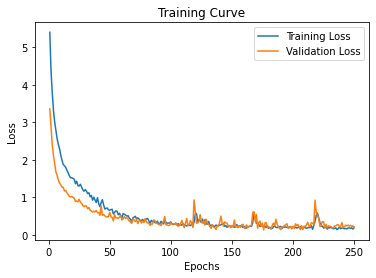

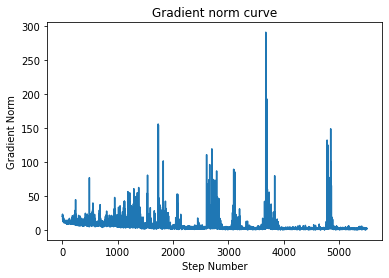

Training Completed.
0.9897360703812317
[[121   0   0   2   0   0   0   0   0   0   1]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  0   0 124   0   0   0   0   0   0   0   0]
 [  5   0   1 118   0   0   0   0   0   0   0]
 [  0   0   0   0 124   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   0 124   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   1   0   0   0   0   0   0 123   0   0]
 [  0   0   0   0   0   0   0   0   0 124   0]
 [  3   0   0   1   0   0   0   0   0   0 120]]


In [54]:
model1 = attn_net2(1,128,256,False,32,0.3,0.2)
model1 = training_triplet(model1,0.0003,250,64,'CrossEntropy',0.9,SoliData('Train',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,False,SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),True,loss_fn)
accu, conf1 = testing_conf(SoliData('Test',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
accu, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
print(np.trace(conf1+conf2)/np.sum(conf1+conf2))
print(conf1+conf2)

In [55]:
torch.save(model1.module.state_dict(),"/content/drive/MyDrive/Saved_Models_BTP/lstm_model_SL.pth")

2-layered model

Data Setup Started
Data Setup Completed
Building model
The loss in iteration 0 was 5.635611761183966
The loss in iteration 1 was 4.18067200978597
The loss in iteration 2 was 3.3791320551009405
The loss in iteration 3 was 2.9582522483099076
The loss in iteration 4 was 2.7442314397721064
The loss in iteration 5 was 2.4638479266847884
The loss in iteration 6 was 2.2775223425456455
The loss in iteration 7 was 2.106167969249544
The loss in iteration 8 was 1.962819667089553
The loss in iteration 9 was 1.851453843570891
The loss in iteration 10 was 1.8027146146410988
The loss in iteration 11 was 1.6639712708336967
The loss in iteration 12 was 1.5866169361841111
The loss in iteration 13 was 1.551783868244716
The loss in iteration 14 was 1.4990048692339943
The loss in iteration 15 was 1.4806111199515206
The loss in iteration 16 was 1.379307122457595
The loss in iteration 17 was 1.3887253971326918
The loss in iteration 18 was 1.2972442223912193
The loss in iteration 19 was 1.2259040418125333
The

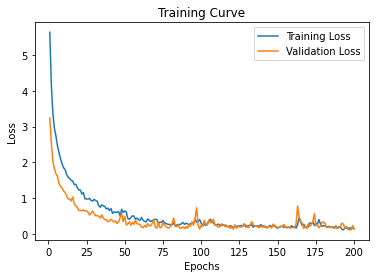

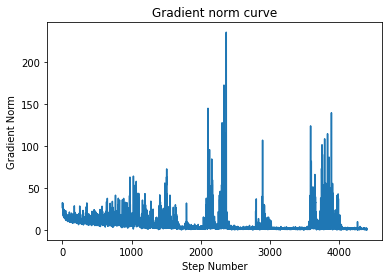

Training Completed.
0.9904692082111437
[[122   0   0   2   0   0   0   0   0   0   0]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  0   0 124   0   0   0   0   0   0   0   0]
 [  2   0   1 121   0   0   0   0   0   0   0]
 [  0   0   0   0 124   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   0 124   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   0   0   0   0   0 124   0]
 [  6   0   0   2   0   0   0   0   0   0 116]]


In [ ]:
model1 = attn_net2(2,128,256,False,32,0.3,0.2)
model1 = training_triplet(model1,0.0003,200,64,'CrossEntropy',0.9,SoliData('Train',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,False,SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),True,loss_fn)
accu, conf1 = testing_conf(SoliData('Test',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
accu, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
print(np.trace(conf1+conf2)/np.sum(conf1+conf2))
print(conf1+conf2)

In [ ]:
torch.save(model1.module.state_dict(),"/content/drive/MyDrive/Saved_Models_BTP/lstm_model.pth")

In [ ]:
device = torch.device('cpu')
model = attn_net2(2,128,256,False,32,0.3,0.2)
model.load_state_dict(torch.load("/content/drive/MyDrive/Saved_Models_BTP/lstm_model.pth", map_location=device))

<All keys matched successfully>

In [ ]:
from timeit import default_timer as timer
start = timer()
accu, conf1 = testing_conf(SoliData('Test',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model,device,'CrossEntropy')
#accu, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model,device,'CrossEntropy')
end = timer()
print(end-start)

6.412041364999823


In [ ]:
print(torch.tensor([X_train_len[0]]).shape)

torch.Size([1])


In [ ]:
ip = torch.tensor(X_test[0]).float()
ip=ip.reshape((1,ip.shape[0],ip.shape[1]))
ip_len = torch.tensor([X_test_len[0]])
print(ip.shape)
print(ip_len)
from timeit import default_timer as timer
start = timer()
op = model(ip,ip_len)
end = timer()
print(end-start)
print(op)

torch.Size([1, 145, 256])
tensor([45])
0.012085764999937965
tensor([[ 5.4562, -1.8781, -1.2753, -0.1550, -2.1295, -1.4023, -0.8332,  0.1668,
         -2.1763, -1.3825, -1.3874]], grad_fn=<AddmmBackward0>)


In [ ]:
print(np.shape(X_train[0]))

(130, 256)


In [ ]:
print(13.113537664999967/1364)

0.009614030546187658


In [ ]:
torch.save(X_test,'/content/drive/MyDrive/Saved_Models_BTP/data.pt')

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
print(conf1+conf2)
print(np.trace(conf1+conf2)/np.sum(conf1+conf2))

[[122   0   0   2   0   0   0   0   0   0   0]
 [  0 124   0   0   0   0   0   0   0   0   0]
 [  0   0 124   0   0   0   0   0   0   0   0]
 [  2   0   1 121   0   0   0   0   0   0   0]
 [  0   0   0   0 124   0   0   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0   0   0]
 [  0   0   0   0   0   0 124   0   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   0   0   0   0   0   0   0 124   0   0]
 [  0   0   0   0   0   0   0   0   0 124   0]
 [  6   0   0   2   0   0   0   0   0   0 116]]
0.9904692082111437


## LOUO

In [ ]:
from torch.utils.data import Dataset

class TestNewUserData(Dataset):
  def __init__(self,train,X_train,y_train,train_len,X_val,y_val,val_len):
        if train:
            self.data= X_train               # in this just define dataset of train and test after split into self.data
            self.target = y_train
            self.len = train_len
        else:
            self.data = X_val
            self.target = y_val 
            self.len = val_len            

  def __getitem__(self, index):
        target = self.target[index]                                                     # gets data point sequentially
        x = self.data[index]
        size = self.len[index]
        return x, target, size

  def __len__(self):
        return len(self.data)                                                      

In [ ]:
import pickle
from random import sample
def get_pruning_data_user(train,user_number,remove_gestures):
  base_n = "/content/drive/MyDrive/data_soli_userwise_dictionaries/"
  users = [2,3,5,6,8,9,10,11,12,13]

  with open(base_n+'train.pickle', 'rb') as f:
    data_tr = pickle.load(f)
  with open(base_n+'test.pickle', 'rb') as f:
    data_te = pickle.load(f)

  X = []
  y = []
  lengths= []
  
  keys = np.zeros(11-len(remove_gestures),dtype=int)
  j=0
  for i in range(11):
    if i not in remove_gestures:
      keys[j]=i
      j= j+1

  keys = list(keys)

  for data in [data_tr,data_te]:
    for key in keys:
      for user in users:

        gesture_data = data[user][key]

        for i in range(len(gesture_data)):
          datapt_arr = gesture_data[i]
          datapt = None
          first = True
          for i in range(4):
            if first:
              datapt = np.sum(datapt_arr[i],axis=2)
              first = False
            else:
              datapt = np.concatenate((datapt,np.sum(datapt_arr[i],axis=2)),axis=1)
          for i in range(4):
            datapt = np.concatenate((datapt,np.sum(datapt_arr[i],axis=1)),axis=1)  

          """
          minimum = datapt.min()
          maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
          datapt = (datapt-minimum)/((maximum-minimum)) 
          """

          if user != user_number:
            if train: 
              X.append(datapt)
              y_temp = np.zeros(11-len(remove_gestures))
              y_temp[keys.index(key)]=1
              y.append(y_temp)
              lengths.append(np.shape(datapt)[0])
          else:
            if not train: 
              X.append(datapt)
              y_temp = np.zeros(11-len(remove_gestures))
              y_temp[keys.index(key)]=1
              y.append(y_temp)
              lengths.append(np.shape(datapt)[0])
        
      
  return X,y,lengths

In [ ]:
from sklearn.model_selection import train_test_split
def test_val_split_user(X_test_use,y_test_use,X_test_len_use,remove):
  X_val =[]
  y_val =[]
  X_test=[]
  y_test=[]
  X_test_len=[]
  X_val_len=[]
  _,counts= np.unique(y_test_use,axis=0,return_counts=True)
  counts = np.flipud(counts)
  for i in range(11-len(remove)):
    count = counts[i]
    val_X,test_X,val_y,test_y,val_len,test_len = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],X_test_len_use[i*count:(i+1)*(count)],test_size=0.50,random_state=2)
    X_val.extend(val_X)
    X_test.extend(test_X)
    y_val.extend(val_y)
    y_test.extend(test_y)
    X_val_len.extend(val_len)
    X_test_len.extend(test_len)
  return X_test,y_test,X_test_len,X_val,y_val,X_val_len

In [ ]:
user = 5
X_train, y_train,X_train_len = get_pruning_data_user(True,user,[])
X_train = padding_data(X_train,X_train_len)

X_test_use, y_test_use,X_test_use_len = get_pruning_data_user(False,user,[])
X_test_use = padding_data(X_test_use,X_test_use_len)

X_test,y_test,X_test_len,X_val,y_val,X_val_len = test_val_split_user(X_test_use,y_test_use,X_test_use_len,[])

2-layered model

In [ ]:
users = [2,3,5,6,8,9,10,11,12,13]
combined_conf=[]
for user in users:

  X_train, y_train,X_train_len = get_pruning_data_user(True,user,[])
  X_train = padding_data(X_train,X_train_len)

  X_test_use, y_test_use,X_test_use_len = get_pruning_data_user(False,user,[])
  X_test_use = padding_data(X_test_use,X_test_use_len)

  X_test,y_test,X_test_len,X_val,y_val,X_val_len = test_val_split_user(X_test_use,y_test_use,X_test_use_len,[])

  model1 = attn_net2(2,128,256,False,32,0.3,0.2)
  model1 = training_triplet(model1,0.0003,200,64,'CrossEntropy',0.9,SoliData('Train',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,False,SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,loss_fn)
  accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
  
  print("for user: "+ str(user))
  print(conf+conf2)
  print((np.trace(conf+conf2)/np.sum(conf+conf2)))
  combined_conf.append((conf+conf2))

In [ ]:
total_conf = None
for i in range(len(combined_conf)):
  if i==0:
    total_conf = combined_conf[i]
  else:
    total_conf += combined_conf[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[222   0   2  20   0   0   0   0   0   0   6]
 [  0 250   0   0   0   0   0   0   0   0   0]
 [  8   0 230   4   4   0   0   0   0   0   4]
 [ 61   0   9 178   1   0   0   0   0   0   1]
 [  0   0   5   1 213   0   0   0   7  24   0]
 [  0   0   0   0   0 247   0   0   0   0   3]
 [  0   0   3   1   0   0 243   0   0   3   0]
 [  0   0   0   0   0   0   0 250   0   0   0]
 [  0  11  10   0   5   0   0   0 221   3   0]
 [  0   0   0   0   1   1   0   0   0 248   0]
 [ 19   0   0   1   0   0   0   0   0   0 230]]
0.9207272727272727


single layer model

Data Setup Started
Data Setup Completed
Building model


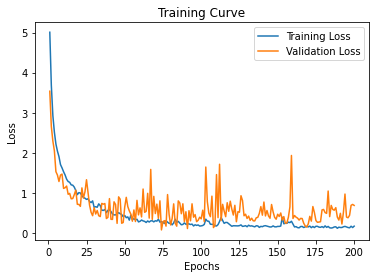

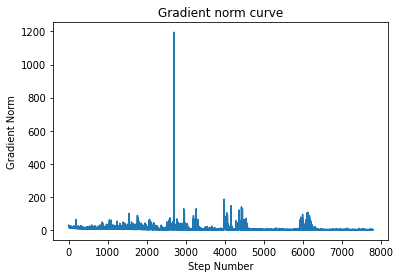

Training Completed.
for user: 2
[[24  0  1  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 0  0  5 20  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  2  0  0  0  1 22  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.9672727272727273
Data Setup Started
Data Setup Completed
Building model


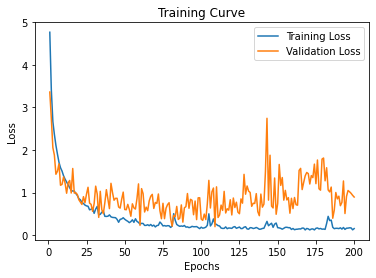

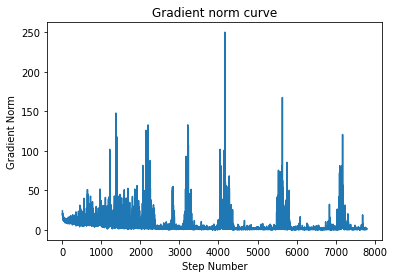

Training Completed.
for user: 3
[[21  0  0  4  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 18  7  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 2  0  0  2  0  0  0  0  0  0 21]]
0.9454545454545454
Data Setup Started
Data Setup Completed
Building model


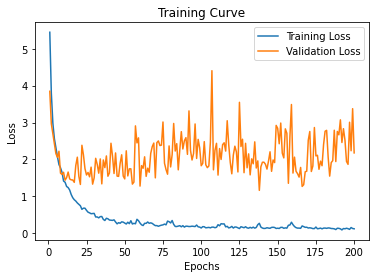

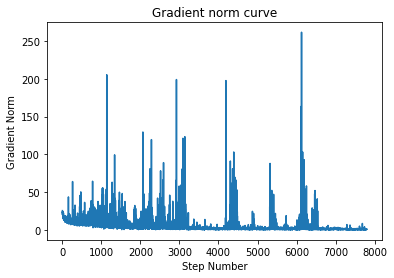

Training Completed.
for user: 5
[[24  0  0  0  0  0  0  0  0  0  1]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  1 22  2  0  0  0  0  0  0  0]
 [24  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 14  1 10  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 3  0  0  0  0  0  0  0  0  0 22]]
0.8327272727272728
Data Setup Started
Data Setup Completed
Building model


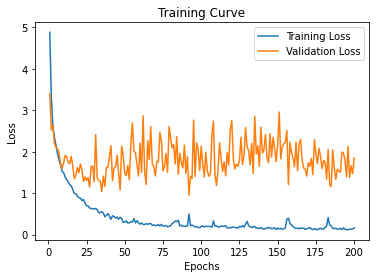

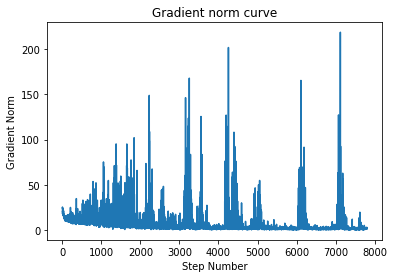

Training Completed.
for user: 6
[[25  0  0  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0 13]
 [ 1  0  0 22  0  0  0  0  0  0  2]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  1  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0 10  0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.9018181818181819
Data Setup Started
Data Setup Completed
Building model


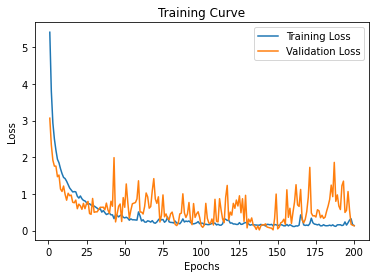

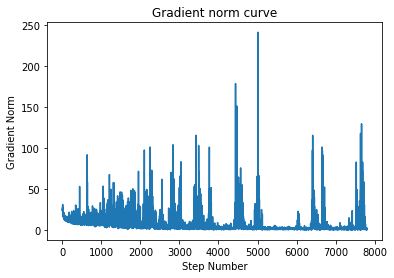

Training Completed.
for user: 8
[[21  0  0  4  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.9854545454545455
Data Setup Started
Data Setup Completed
Building model


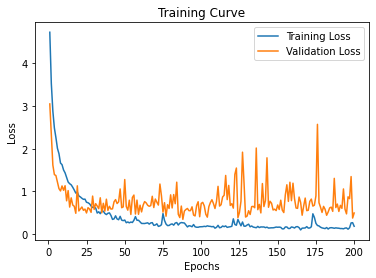

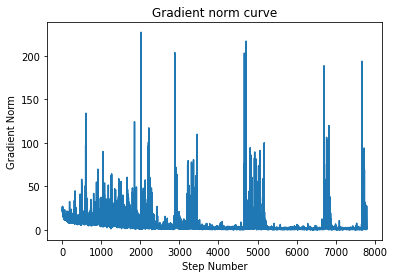

Training Completed.
for user: 9
[[11  0  0 13  0  0  0  0  0  0  1]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 24  0  1  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.9454545454545454
Data Setup Started
Data Setup Completed
Building model


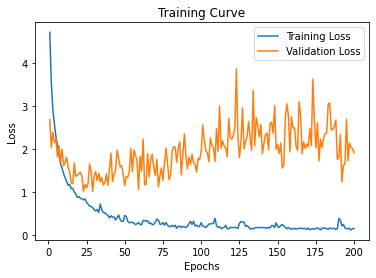

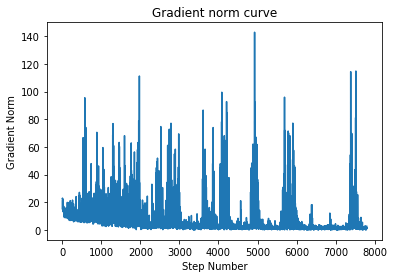

Training Completed.
for user: 10
[[12  0  1 12  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 1  0  0 24  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 23  0  0  0  2  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 7  0  0  0  0  0  0  0  0  0 18]]
0.9163636363636364
Data Setup Started
Data Setup Completed
Building model


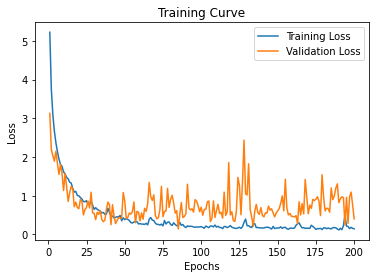

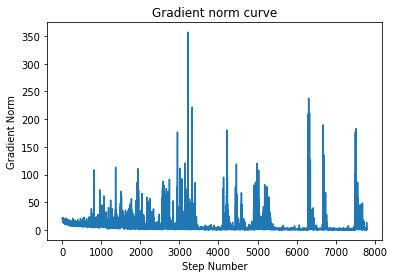

Training Completed.
for user: 11
[[21  0  0  3  0  0  0  0  0  0  1]
 [ 0 23  0  0  0  0  0  0  2  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  5  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.96
Data Setup Started
Data Setup Completed
Building model


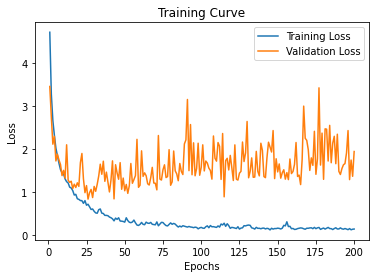

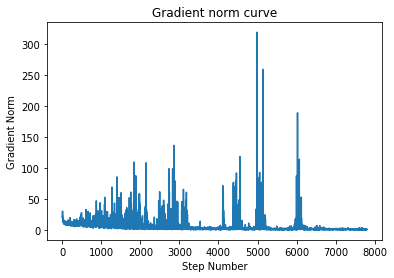

Training Completed.
for user: 12
[[24  0  0  0  0  0  0  0  0  0  1]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [22  0  2  0  0  0  0  0  0  0  1]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  1  0]
 [ 0  0  0  4  0  0 21  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.8872727272727273
Data Setup Started
Data Setup Completed
Building model


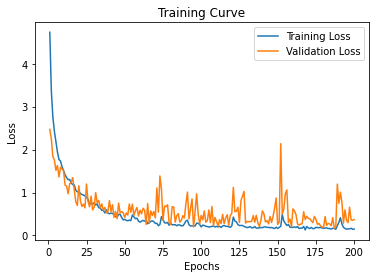

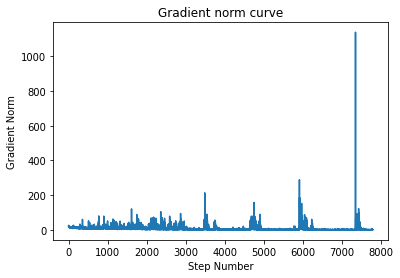

Training Completed.
for user: 13
[[24  0  0  0  0  0  0  0  0  0  1]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 3  0  1 21  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  1  8  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.9490909090909091


In [ ]:
users = [2,3,5,6,8,9,10,11,12,13]
combined_conf=[]
for user in users:

  X_train, y_train,X_train_len = get_pruning_data_user(True,user,[])
  X_train = padding_data(X_train,X_train_len)

  X_test_use, y_test_use,X_test_use_len = get_pruning_data_user(False,user,[])
  X_test_use = padding_data(X_test_use,X_test_use_len)

  X_test,y_test,X_test_len,X_val,y_val,X_val_len = test_val_split_user(X_test_use,y_test_use,X_test_use_len,[])

  model1 = attn_net2(1,128,256,False,32,0.3,0.2)
  model1 = training_triplet(model1,0.0003,200,64,'CrossEntropy',0.9,SoliData('Train',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,False,SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,loss_fn)
  accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
  
  print("for user: "+ str(user))
  print(conf+conf2)
  print((np.trace(conf+conf2)/np.sum(conf+conf2)))
  combined_conf.append((conf+conf2))

In [ ]:
total_conf = None
for i in range(len(combined_conf)):
  if i==0:
    total_conf = combined_conf[i]
  else:
    total_conf += combined_conf[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[207   0   2  36   0   0   0   0   0   0   5]
 [  0 248   0   0   0   0   0   0   2   0   0]
 [  0   1 226   9   1   0   0   0   0   0  13]
 [ 51   0   8 188   0   0   0   0   0   0   3]
 [  0   0  14   1 221   0   0   0   1  13   0]
 [  0   0   0   0   0 246   0   0   0   4   0]
 [  0   0   0   4   0   0 246   0   0   0   0]
 [  0   0   0   0   0   0   0 250   0   0   0]
 [  0  10   0   0   0   0   0   0 240   0   0]
 [  0   0   0   0   2   0   0   0   1 247   0]
 [ 12   0   0   2   0   0   0   0   0   0 236]]
0.9290909090909091


## LOSO

In [ ]:
import pickle
from random import sample
def get_pruning_data_session(train,sess,remove_gestures):
  base_n = "/content/drive/MyDrive/session_wise_data/"

  sessions = [0,1,4,7,13,14]
  with open(base_n+'train.pickle', 'rb') as f:
    data_tr = pickle.load(f)
  with open(base_n+'test.pickle', 'rb') as f:
    data_te = pickle.load(f)

  if train:
    sessions.remove(sess)
    
  else:
    sessions = [sess]

  X = []
  y = []
  lengths= []
  
  keys = np.zeros(11-len(remove_gestures),dtype=int)
  j=0
  for i in range(11):
    if i not in remove_gestures:
      keys[j]=i
      j= j+1

  keys = list(keys)

  for key in keys:
    for session in sessions:

      if session != 14 and session != 7 and session != 4:
        data = data_tr
      else:
        data = data_te

      gesture_data = data[session][key]
      for i in range(len(gesture_data)):
        datapt_arr = gesture_data[i]
        datapt = None
        first = True
        for i in range(4):
          if first:
            datapt = np.sum(datapt_arr[i],axis=2)
            first = False
          else:
            datapt = np.concatenate((datapt,np.sum(datapt_arr[i],axis=2)),axis=1)
        for i in range(4):
          datapt = np.concatenate((datapt,np.sum(datapt_arr[i],axis=1)),axis=1)  

        """
        minimum = datapt.min()
        maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
        datapt = (datapt-minimum)/((maximum-minimum)) 
        """

        X.append(datapt)
        y_temp = np.zeros(11-len(remove_gestures))
        y_temp[keys.index(key)]=1
        y.append(y_temp)
        lengths.append(np.shape(datapt)[0])
        
      
  return X,y,lengths

In [ ]:
from sklearn.model_selection import train_test_split
def test_val_split_session(X_test_use,y_test_use,X_test_len_use,remove):
  X_val =[]
  y_val =[]
  X_test=[]
  y_test=[]
  X_test_len=[]
  X_val_len=[]

  _,count = np.unique(y_test_use,axis=0,return_counts=True)
  count = count[0]

  for i in range(11-len(remove)):
    val_X,test_X,val_y,test_y,val_len,test_len = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],X_test_len_use[i*count:(i+1)*(count)],test_size=0.50,random_state=2)
    X_val.extend(val_X)
    X_test.extend(test_X)
    y_val.extend(val_y)
    y_test.extend(test_y)
    X_val_len.extend(val_len)
    X_test_len.extend(test_len)
  return X_test,y_test,X_test_len,X_val,y_val,X_val_len

2-layered model

In [ ]:
sessions = [0,1,4,7,13,14]
combined_conf=[]
for session in sessions:

  X_train, y_train,X_train_len= get_pruning_data_session(True,session,[])
  X_train = padding_data(X_train,X_train_len)

  X_test_use, y_test_use,X_test_use_len = get_pruning_data_session(False,session,[])
  X_test_use = padding_data(X_test_use,X_test_use_len)

  X_test,y_test,X_test_len,X_val,y_val,X_val_len = test_val_split_session(X_test_use,y_test_use,X_test_use_len,[])

  model1 = attn_net2(2,128,256,False,32,0.3,0.2)
  model1 = training_triplet(model1,0.0003,200,64,'CrossEntropy',0.9,SoliData('Train',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,False,SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,loss_fn)
  accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')

  print("for session: "+ str(session))
  print(conf+conf2)
  print((np.trace(conf+conf2)/np.sum(conf+conf2)))
  combined_conf.append((conf+conf2))

In [ ]:
total_conf = None
for i in range(len(combined_conf)):
  if i==0:
    total_conf = combined_conf[i]
  else:
    total_conf += combined_conf[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[233   0   1   4   0   0   0   0   0   0  12]
 [  0 249   0   0   1   0   0   0   0   0   0]
 [  0   0 245   5   0   0   0   0   0   0   0]
 [ 29   0   0 212   0   0   0   0   0   0   9]
 [  0   0   3   0 238   0   0   0   8   1   0]
 [  0   0   0   0   0 250   0   0   0   0   0]
 [  0   0   0   0   0   0 250   0   0   0   0]
 [  0   0   0   0   0   0   0 250   0   0   0]
 [  0   0   0   0   0   0   0   0 250   0   0]
 [  0   0   0   0   0   0   0   0   0 250   0]
 [ 17   0   0  13   0   0   0   0   0   0 220]]
0.9625454545454546


single layered model

Data Setup Started
Data Setup Completed
Building model


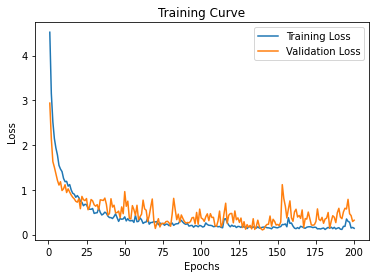

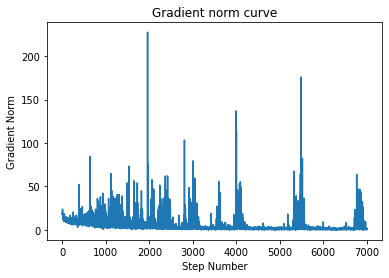

Training Completed.
for session: 0
[[44  0  0  2  0  0  0  0  0  0  4]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0]
 [ 2  0  0 46  0  0  0  0  0  0  2]
 [ 0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0]
 [ 3  0  0  0  0  0  0  0  0  0 47]]
0.9763636363636363
Data Setup Started
Data Setup Completed
Building model


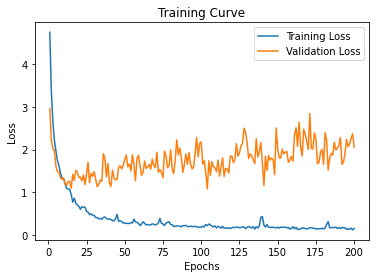

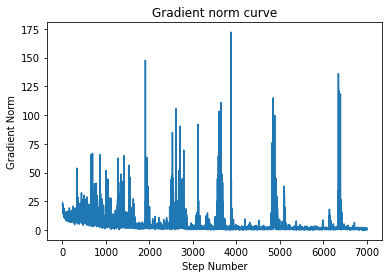

Training Completed.
for session: 1
[[42  0  0  0  0  0  0  0  0  0  8]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0]
 [30  0  2 15  0  0  0  0  0  0  3]
 [ 0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0 49  0  0  0  1  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0]
 [ 1  0  0 11  0  0  0  0  0  0 38]]
0.8981818181818182
Data Setup Started
Data Setup Completed
Building model


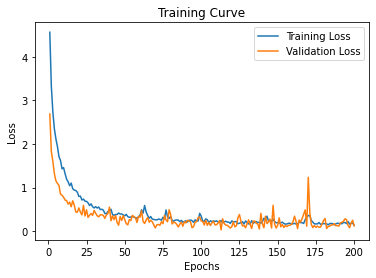

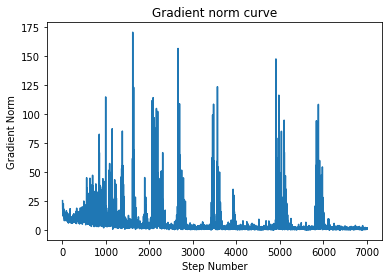

Training Completed.
for session: 4
[[47  0  0  1  0  0  0  0  0  0  2]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0]
 [ 1  0  0 49  0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0 50]]
0.9927272727272727
Data Setup Started
Data Setup Completed
Building model


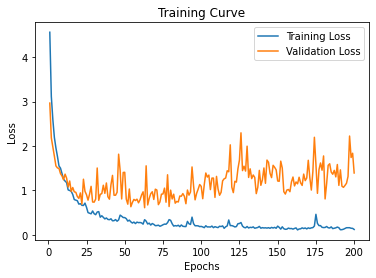

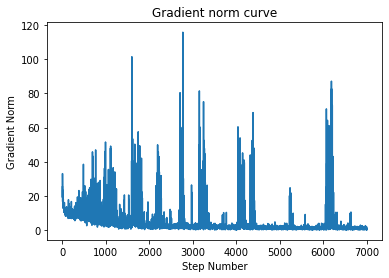

Training Completed.
for session: 7
[[47  0  0  2  0  0  0  0  0  0  1]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0 33 17  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0]
 [ 0  0  1  1 47  1  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0]
 [14  0  0  3  0  0  0  0  0  0 33]]
0.9272727272727272
Data Setup Started
Data Setup Completed
Building model


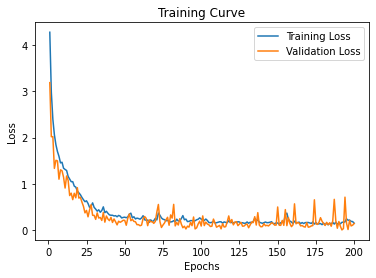

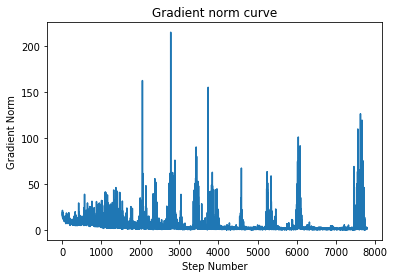

Training Completed.
for session: 13
[[22  0  0  2  0  0  0  0  0  0  1]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 1  0  0  0  0  0  0  0  0  0 24]]
0.9854545454545455
Data Setup Started
Data Setup Completed
Building model


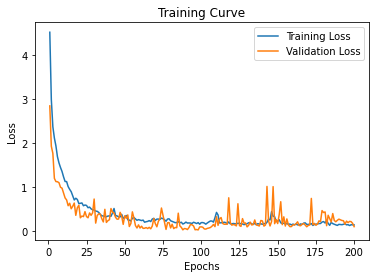

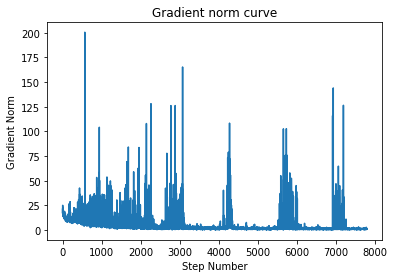

Training Completed.
for session: 14
[[25  0  0  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0 24  0  0  0  1  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 1  0  0  1  0  0  0  0  0  0 23]]
0.9890909090909091


In [ ]:
sessions = [0,1,4,7,13,14]
combined_conf=[]
for session in sessions:

  X_train, y_train,X_train_len= get_pruning_data_session(True,session,[])
  X_train = padding_data(X_train,X_train_len)

  X_test_use, y_test_use,X_test_use_len = get_pruning_data_session(False,session,[])
  X_test_use = padding_data(X_test_use,X_test_use_len)

  X_test,y_test,X_test_len,X_val,y_val,X_val_len = test_val_split_session(X_test_use,y_test_use,X_test_use_len,[])

  model1 = attn_net2(1,128,256,False,32,0.3,0.2)
  model1 = training_triplet(model1,0.0003,200,64,'CrossEntropy',0.9,SoliData('Train',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,False,SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,loss_fn)
  accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')

  print("for session: "+ str(session))
  print(conf+conf2)
  print((np.trace(conf+conf2)/np.sum(conf+conf2)))
  combined_conf.append((conf+conf2))

In [ ]:
total_conf = None
for i in range(len(combined_conf)):
  if i==0:
    total_conf = combined_conf[i]
  else:
    total_conf += combined_conf[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[227   0   0   7   0   0   0   0   0   0  16]
 [  0 250   0   0   0   0   0   0   0   0   0]
 [  0   0 233  17   0   0   0   0   0   0   0]
 [ 33   0   2 210   0   0   0   0   0   0   5]
 [  0   0   1   1 246   1   0   0   1   0   0]
 [  0   0   0   0   0 249   0   0   0   1   0]
 [  0   0   0   0   0   0 250   0   0   0   0]
 [  0   0   0   0   0   0   0 250   0   0   0]
 [  0   0   0   0   0   0   0   0 250   0   0]
 [  0   0   0   0   0   0   0   0   0 250   0]
 [ 20   0   0  15   0   0   0   0   0   0 215]]
0.9563636363636364


Data Setup Started
Data Setup Completed
Building model


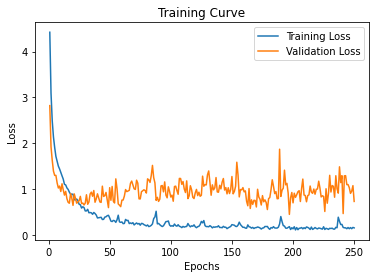

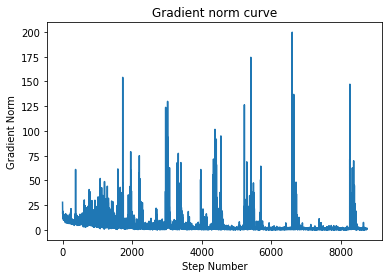

Training Completed.
for session: 0
[[39  0  0  1  0  0  0  0  0  0 10]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0]
 [ 2  0  0 45  0  0  0  0  0  0  3]
 [ 0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0]
 [ 2  0  0  0  0  0  0  0  0  0 48]]
0.9672727272727273
Data Setup Started
Data Setup Completed
Building model


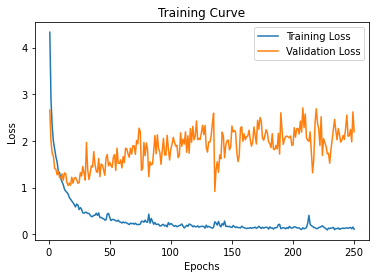

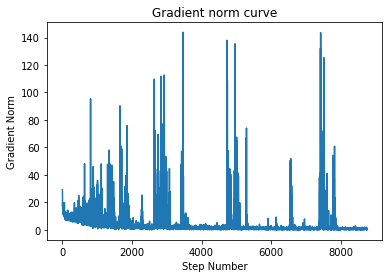

Training Completed.
for session: 1
[[44  0  0  0  0  0  0  0  0  0  6]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0]
 [33  0  0 17  0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0 13  0  0  0  0  0  0 37]]
0.9054545454545454
Data Setup Started
Data Setup Completed
Building model


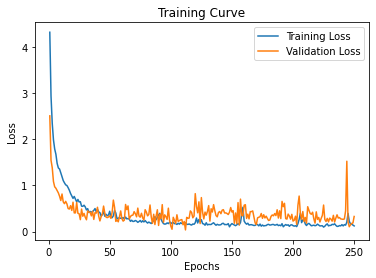

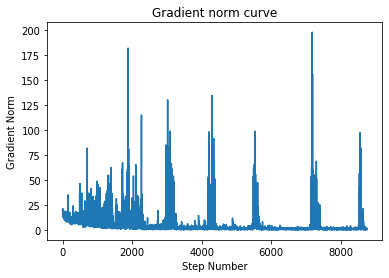

Training Completed.
for session: 4
[[47  0  0  1  0  0  0  0  0  0  2]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0]
 [ 1  0  0 49  0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0 50]]
0.9927272727272727
Data Setup Started
Data Setup Completed
Building model


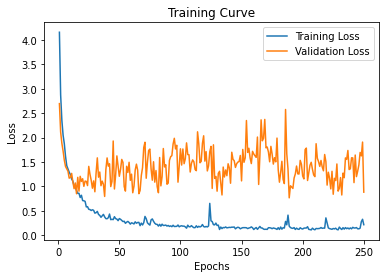

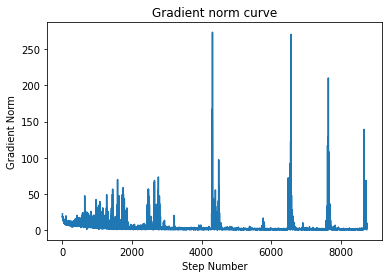

Training Completed.
for session: 7
[[50  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0 42  8  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0]
 [ 0  0  2  0 38 10  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0]
 [11  0  0  2  0  0  0  0  0  0 37]]
0.94
Data Setup Started
Data Setup Completed
Building model


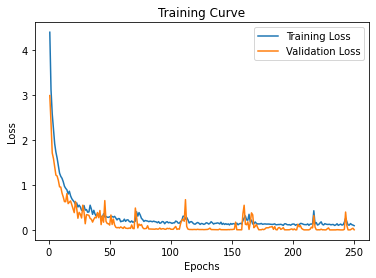

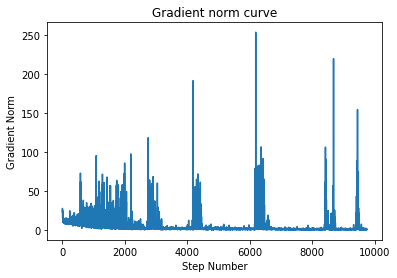

Training Completed.
for session: 13
[[25  0  0  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 0  0  1 24  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.9963636363636363
Data Setup Started
Data Setup Completed
Building model


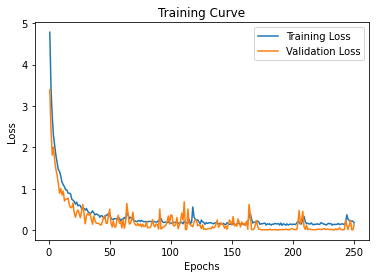

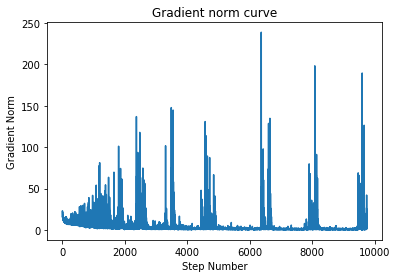

Training Completed.
for session: 14
[[25  0  0  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 4  0  0  0  0  0  0  0  0  0 21]]
0.9854545454545455


In [56]:
sessions = [0,1,4,7,13,14]
combined_conf=[]
for session in sessions:

  X_train, y_train,X_train_len= get_pruning_data_session(True,session,[])
  X_train = padding_data(X_train,X_train_len)

  X_test_use, y_test_use,X_test_use_len = get_pruning_data_session(False,session,[])
  X_test_use = padding_data(X_test_use,X_test_use_len)

  X_test,y_test,X_test_len,X_val,y_val,X_val_len = test_val_split_session(X_test_use,y_test_use,X_test_use_len,[])

  model1 = attn_net2(1,128,256,False,32,0.3,0.2)
  model1 = training_triplet(model1,0.0003,250,64,'CrossEntropy',0.9,SoliData('Train',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,False,SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),False,loss_fn)
  accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_train_len,X_test,y_test,X_test_len,X_val,y_val,X_val_len),model1,device,'CrossEntropy')

  print("for session: "+ str(session))
  print(conf+conf2)
  print((np.trace(conf+conf2)/np.sum(conf+conf2)))
  combined_conf.append((conf+conf2))

In [57]:
total_conf = None
for i in range(len(combined_conf)):
  if i==0:
    total_conf = combined_conf[i]
  else:
    total_conf += combined_conf[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[230   0   0   2   0   0   0   0   0   0  18]
 [  0 250   0   0   0   0   0   0   0   0   0]
 [  0   0 242   8   0   0   0   0   0   0   0]
 [ 36   0   1 210   0   0   0   0   0   0   3]
 [  0   0   2   0 238  10   0   0   0   0   0]
 [  0   0   0   0   0 250   0   0   0   0   0]
 [  0   0   0   0   0   0 250   0   0   0   0]
 [  0   0   0   0   0   0   0 250   0   0   0]
 [  0   0   0   0   0   0   0   0 250   0   0]
 [  0   0   0   0   0   0   0   0   0 250   0]
 [ 17   0   0  15   0   0   0   0   0   0 218]]
0.9592727272727273
